In [106]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, plot_roc_curve

!pip install catboost
from catboost import CatBoostClassifier

In [7]:
data = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt',sep='\t',header=None).values.flatten()

Меняем метки -1 на 0 для удобства 

In [8]:
labels[labels == -1] = 0

In [9]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([37024,  2976]))

Сразу же разделим датасет на тренировочную и тестовую выборку (с размером 0.5 от первоначальной).  
На первой будем проводить обучение, на второй - строить бизнес-модель.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=314)

# 0. Построение модели

In [11]:
def preprocessing(train, test, na_share=0.75, unique_cat=None):
  train_num = train.iloc[:,:190]
  train_cat = train.iloc[:,190:]
  test_num = test.iloc[:,:190]
  test_cat = test.iloc[:,190:]
  # для начала надо отсеять признаки с большой долей пропущенных значений
  share = na_share
  train_num_full = train_num.loc[:,train_num.isnull().sum() < len(train_num) * share]
  train_cat_full = train_cat.loc[:, train_cat.isnull().sum() < len(train_cat) * share]
  test_num_full = test_num.loc[:,test_num.isnull().sum() < len(test_num) * share]
  test_cat_full = test_cat.loc[:, test_cat.isnull().sum() < len(test_cat) * share]
  # Из 230 признаков осталось 76: 42 дискретных и 34 категориальных

  # Соединяем тренировочную и тестовую выборки для дальнейшей предобработки
  cat_full_data = pd.concat([train_cat_full, test_cat_full])
  num_full_data = pd.concat([train_num_full, test_num_full])

  # Выбрасываем переменные с 300 и более уникальными значениями так как они могут серьёзно утяжелить данные после применения One-Hot Encoding
  if unique_cat is not None:
    na_cat = cat_full_data.describe().T
    cat_full_data.drop(na_cat.query('unique >= @unique_cat').index, axis=1, inplace=True)
  full_data = pd.concat([num_full_data, cat_full_data], axis=1)

  # Для дискретных принаков будем заменять NA медианой и масштабировать
  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean')), 
      ('scaler', StandardScaler())])

  # Для категориальных принаков будем замерять NA отдельным уникальым значением и применять One-Hot Encoding
  categor_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant'))])
      #('encoder', OneHotEncoder(drop='first'))])

  #находим, с какого индекса начинаются категориальные 
  cat_threshold = list(full_data).index(full_data.dtypes[full_data.dtypes == 'object'].index[0])

  # Собираем в один трансформер
  preprocessor = ColumnTransformer(transformers=[
      ('numeric_transformer', numeric_transformer, full_data.columns[:cat_threshold]),
      ('categor_transformer', categor_transformer, full_data.columns[cat_threshold:])])
  
  # Преобразовываем данные
  features_full = preprocessor.fit_transform(full_data)
  threshold = train_cat_full.shape[0]

  # Снова разделяем на тестовую и тренировочную выборки
  all_cols = list(num_full_data.columns) + list(cat_full_data.columns)
  features_train = pd.DataFrame(features_full[:threshold], columns=all_cols)
  features_test = pd.DataFrame(features_full[threshold:], columns=all_cols)
  
  return features_train, features_test, cat_threshold

In [12]:
features_train, features_test, cat_threshold = preprocessing(X_train, X_test)

0.7424717169798608


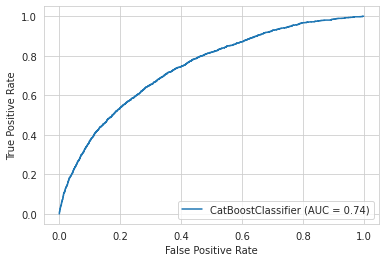

In [117]:
def catboost(features_train, features_test, y_train, y_test, cat_threshold):
  cat_features = list(features_train)[cat_threshold:]
  classes = class_weight.compute_sample_weight('balanced', np.unique(y_train), y_train)

  catboost_classifier = CatBoostClassifier(iterations=300, depth=3, l2_leaf_reg=5, learning_rate=0.05, 
                                         loss_function= 'Logloss', class_weights = classes, 
                                         eval_metric = 'AUC', cat_features = cat_features)
  catboost_classifier.fit(features_train, y_train, eval_set=(features_test, y_test), verbose=False, early_stopping_rounds=10)
  
  pred = catboost_classifier.predict_proba(features_test)[:, 1]
  print(roc_auc_score(y_test, pred))
  plot_roc_curve(catboost_classifier, features_test, y_test)
  probs = pd.DataFrame({'pred' : pred, 'labels' : y_test}).sort_values(by='pred', ascending=False)
  return probs
probs = catboost(features_train, features_test, y_train, y_test, cat_threshold)

# 1. Постановка задачи и бизнес-модель

Определим первый вариант бизнес-модели

1. Определяется $N$ пользователей мобильного оператора, по прогнозу наиболее склонных к оттоку на основании предсказания
2. Им рассылается SMS с предложением подключить бесплатный, включающий определённое количество гигабайт интернет-трафика и минут звонков в роуминге на протяжение $m$ месяцев. Подсчитано, что себестоимость реализации пакета в расчёте на одного пользователя в среднем будет равна $b$ рублей.
3. Пользователи $O$, не склонные к оттоку, в любом случае воспользуются предложением.
4. С вероятностью $s$ процентов пользователи, склонные к оттоку (из количества, равного $C$), останутся клиентом фирмы, останется клиентом фирмы, будет использовать подключённый пакет и платить за связь в том же объёме, что и все остальные пользователи. 
5. Также услуга будет предлагаться всем $NU$ процентам новых пользователей каждый месяц до $m + 1$-ого месяца (с момента начала отсчёта). 
6. Новые пользователи будут также платить по тарифам столько же, сколько и все остальные. $92.5%$ останутся пользователями. Остальные используют весь предоставляемый пакет и перестанут пользоваться услугами мобильного оператора.
7. Будем сравнивать прибыль: 1) после проведения кампании по удержанию при разном количестве пользователей; 2) без проведения кампании по удержанию

In [319]:
def campaign(N, p, A, m, s, NU, probs):
  C = probs[:N].query('labels == 1').shape[0] #правильно определённые клиенты
  Rest = probs[N:].query('labels == 0').shape[0] #клиенты, не склонные к оттоку и не вошедшие в топ

  Revenue_old = C * s * p * m + Rest * p #доход за m месяцев от доли пользователей, решивших остаться
  Cost =  N * A # затраты на удержание выбранных пользователей

  Revenue_new = 0
  old_users = probs.shape[0] #количество пользователей из первоначальной выборки
  for i in range(m):
    new_users = NU * old_users # вычисляем количество новых пользователей за месяц
    Revenue_new += p * 0.925 * new_users * (m - i)  #доход, который сгенерируют новые пользователи до конца периода 
    Cost +=  new_users * A #затраты на новых пользователей
    old_users += new_users * 0.925 #общее количество пользователей увеличивается

  Profit = Revenue_old - Cost
  Profit = Revenue_new + Revenue_old - Cost
  return Profit

In [318]:
def campaign_metrics(p, A, m, s, NU, probs):
  top_n, top_prec = [], []
  for i in np.arange(0.01, 0.92, 0.01):
    n = probs[probs['pred'] > i].shape[0]
    pr = probs[:n][probs['labels'] == 1].shape[0]
    share = pr / n
    top_n.append(n)
    top_prec.append((pr, share))
  campaign_list = []
  for n in top_n:
    campaign_list.append(campaign(n, p, A, m, s, NU, probs))
      
  plt.figure(figsize=(14,7))
  plt.plot(top_n, campaign_list,  color="g")
  plt.plot(top_n, campaign_list,  color="g")
  plt.plot(top_n, np.ones(len(top_n))*200*probs.query('labels==0').shape[0], ':',  color="r" )
  plt.title('Зависимость экономического эффекта от размера выборки')
  plt.grid(True)
  plt.xlabel('Размер выборки')
  plt.ylabel('Эффект(руб.)')
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.yticks(rotation=45)
  plt.show()

  income_sample = sorted(list(zip(campaign_list, top_n)), key = lambda x: x[0], reverse=True)
  print(f'Наиболее оптимальным порогом являются {income_sample[0][1]} пользователей, ' 
  f'участвующих в кампании по удержанию, или {round((income_sample[0][1] / y_test.shape[0] * 100),1)}% от общего количества')

# Задание 2

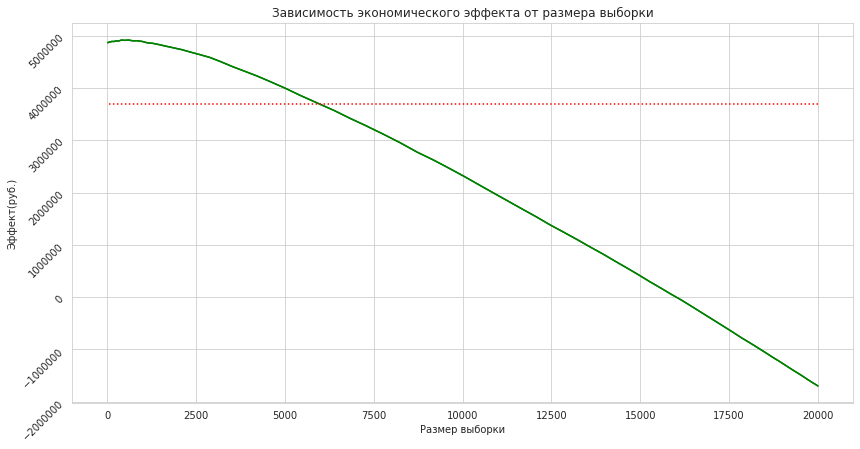

Наиболее оптимальным порогом являются 594 пользователей, участвующих в кампании по удержанию, или 3.0% от общего количества


In [312]:
campaign_metrics(200, 250, 12, 0.6, 0.005, probs)

# Задание 3

1. Определяется $N$ пользователей, по прогнозу наиболее склонных к оттоку на основании предсказания
2. Им рассылается SMS с предложением воспользоваться скидкой, после которой стоимость тарифа будет равна d, что меньше суммы p, которую платят все остальные пользователи,  которая будет длиться на протяжении $m$ месяцев.
3. Пользователи $O$, не склонные к оттоку, в любом случае воспользуются предложением.
4. С вероятностью $s$ процентов пользователь, склонный к оттоку (из количество равно $C$), примет предложение скидки и в последствии останется пользователем компании.
5. Также скидочный тариф будет предлагаться всем $NU$ процентам новых пользователей кадый месяц до m-ого месяца (с момента начала отсчёта).



 





1. Определяется $N$ пользователей мобильного оператора, по прогнозу наиболее склонных к оттоку на основании предсказания
2. Им рассылается SMS с предложением подключить более дешёвый тариф, чья стоимость будет сосвавлять долю $d$ от стандартного тарифа стоимостью $p$ на протяжение m месяцев. 
3. Пользователи $O$, не склонные к оттоку, в любом случае воспользуются предложением до окончания периода предложения
4. С вероятностью $s$ процентов пользователи, склонные к оттоку (из количества, равного $C$), останутся клиентом фирмы, воспользуются скидкой и будет пользоваться до окончания периода предложения.
5. Также скидка будет предлагаться всем $NU$ процентам новых пользователей каждый месяц до $m + 1$-ого месяца (с момента начала отсчёта). 
6. $92.5%$ останутся пользователями. Остальные перестанут пользоваться фирмы после 1 месяца использования
7. Будем сравнивать прибыль: 1) после проведения кампании по удержанию при разном количестве пользователей; 2) без проведения кампании по удержанию.

In [334]:
def campaign2(N, p, d, m, s, NU, probs):
  C = probs[:N].query('labels == 1').shape[0] #правильно определённые клиенты
  Rest = probs[N:].query('labels == 0').shape[0] #клиенты, не склонные к оттоку и не вошедшие в топ

  Revenue_old = C * s * p * (1-d) * m + Rest * p #доход за m месяцев от доли пользователей, решивших остаться
  Cost =  (N-C) * p * d # затраты на удержание выбранных пользователей

  Revenue_new = 0
  old_users = probs.shape[0] #количество пользователей из первоначальной выборки
  for i in range(m):
    new_users = NU * old_users # вычисляем количество новых пользователей за месяц
    Revenue_new += p * (1-d) * (m - i) * new_users * 0.925  + 0.075 * p * (1-d) * new_users #доход, который сгенерируют новые пользователи до конца периода 
    Cost +=  new_users * d * p #затраты на новых пользователей
    old_users += new_users * 0.925 #общее количество пользователей увеличивается

  Profit = Revenue_new + Revenue_old - Cost
  return Profit

In [357]:
def campaign_metrics_2(p, d, m, s, NU, probs):
  top_n, top_prec = [], []
  for i in np.arange(0.01, 0.92, 0.01):
    n = probs[probs['pred'] > i].shape[0]
    pr = probs[:n][probs['labels'] == 1].shape[0]
    share = pr / n
    top_n.append(n)
    top_prec.append((pr, share))
  campaign_list = []
  for n in top_n:
    campaign_list.append(campaign2(n, p, d, m, s, NU, probs))

  plt.figure(figsize=(14,7))
  plt.plot(top_n, campaign_list,  color="g")
  plt.plot(top_n, campaign_list,  color="g")
  plt.plot(top_n, np.ones(len(top_n))*200*probs.query('labels==0').shape[0], ':',  color="r" )
  plt.title('Зависимость экономического эффекта от размера выборки')
  plt.grid(True)
  plt.xlabel('Размер выборки')
  plt.ylabel('Эффект(руб.)')
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.yticks(rotation=45)
  plt.show()

  income_sample = sorted(list(zip(campaign_list, top_n)), key = lambda x: x[0], reverse=True)
  print(f'Наиболее оптимальным порогом являются {income_sample[0][1]} пользователей, ' 
  f'участвующих в кампании по удержанию, или {round((income_sample[0][1] / y_test.shape[0] * 100),1)}% от общего количества')

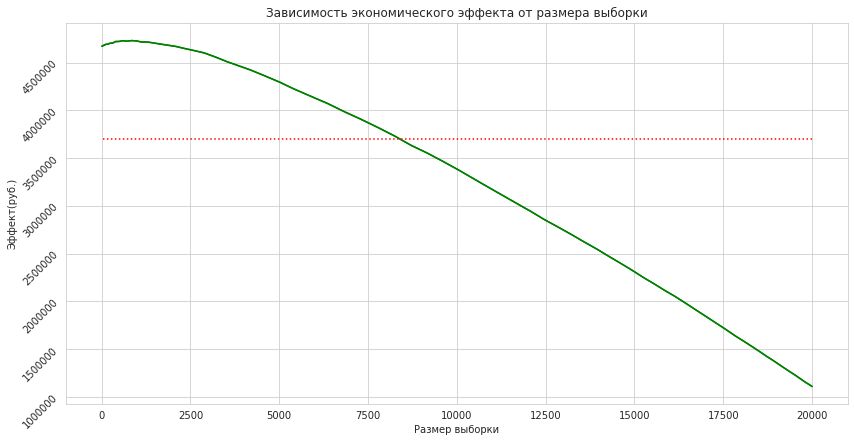

Наиболее оптимальным порогом являются 839 пользователей, участвующих в кампании по удержанию, или 4.2% от общего количества


In [372]:
campaign_metrics_2(200, 0.3, 12, 0.5, 0.005, probs)

# Задание 4

Попробуем повысить себестоимость акции до 280 рублей и повысить вероятность, с которой пользователи, склонные к оттоку, останутся клиентами, до 80%, а также повысить процент новых пользователей, приходящих каждый месяц, до 1.2%

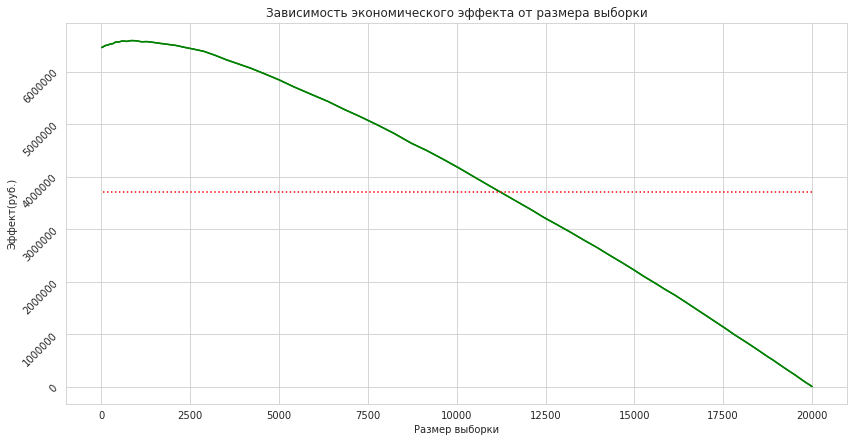

Наиболее оптимальным порогом являются 839 пользователей, участвующих в кампании по удержанию, или 4.2% от общего количества


In [367]:
campaign_metrics(200, 280, 12, 0.8, 0.012, probs)

Доходность первой модели при увеличенной себестоимости повысилась, а оптимальный порог поднялся до 4.2%.
Хотя мы можем только предполагать о темпах притока новых клиентов и вероятности, с которой пользователи, склонные к оттоку, останутся клиентами, в дальнейшем мы будем пользоваться этой моделью. 

Попробуем повысить размер скидки до 70% и повысить вероятность, с которой пользователи, склонные к оттоку, воспользуются ей, до 60%, а также повысить процент новых пользователей, приходящих каждый месяц, до 1%

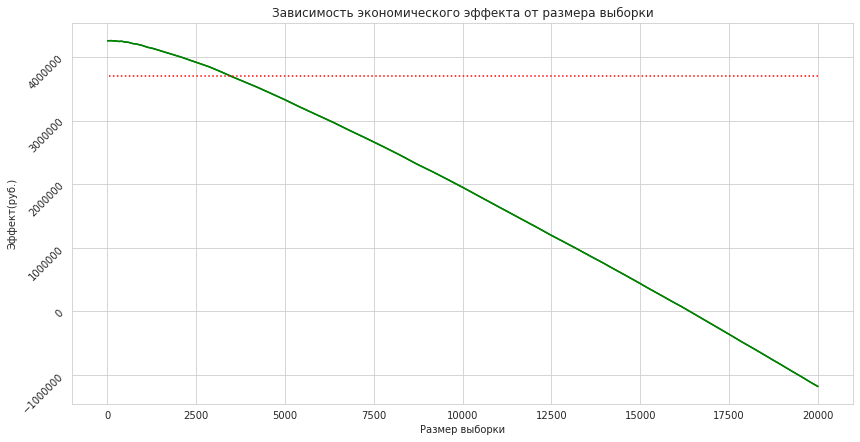

Наиболее оптимальным порогом являются 87 пользователей, участвующих в кампании по удержанию, или 0.4% от общего количества


In [371]:
campaign_metrics_2(200, 0.7, 12, 0.8, 0.01, probs)

Как видно, общая доходность второй модели при высокой скидке и большей привлекательности для новых клиентов значительно повысилась. Оптимальный порог также повысился до 22.9%.  
С учётом того, что мы можем только предполагать о темпах притока новых клиентов и вероятности, с которой пользователи, склонные к оттоку, останутся клиентами, применение модели скорее невыгодно 
Для увеличения доходности стоит выбирать меньший объём скидки.

# Задание 5

0.7138175702363361


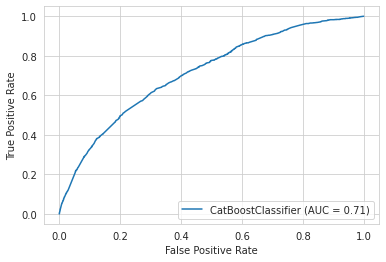

In [152]:
def catboost1(features_train, features_test, y_train, y_test, cat_threshold):
  cat_features = list(features_train)[cat_threshold:]
  classes = class_weight.compute_sample_weight('balanced', np.unique(y_train), y_train)

  catboost_classifier = CatBoostClassifier(iterations=150, depth=3,  learning_rate=0.01, 
                                         loss_function= 'Logloss', class_weights = classes, 
                                         eval_metric = 'AUC', cat_features = cat_features)
  catboost_classifier.fit(features_train, y_train, eval_set=(features_test, y_test), verbose=False, early_stopping_rounds=10)
  
  pred = catboost_classifier.predict_proba(features_test)[:, 1]
  print(roc_auc_score(y_test, pred))
  plot_roc_curve(catboost_classifier, features_test, y_test)
  probs = pd.DataFrame({'pred' : pred, 'labels' : y_test}).sort_values(by='pred', ascending=False)
  return probs
probs1 = catboost1(features_train, features_test, y_train, y_test, cat_threshold)

0.7235023482298026


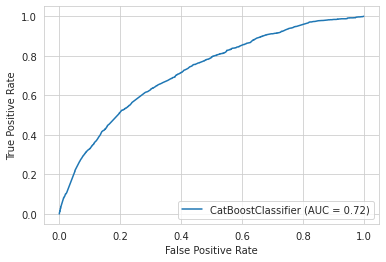

In [146]:
def catboost2(features_train, features_test, y_train, y_test, cat_threshold):
  cat_features = list(features_train)[cat_threshold:]
  classes = class_weight.compute_sample_weight('balanced', np.unique(y_train), y_train)

  catboost_classifier = CatBoostClassifier(iterations=150, depth=3, l2_leaf_reg=5, learning_rate=0.017, 
                                         loss_function= 'Logloss', class_weights = classes, 
                                         eval_metric = 'AUC', cat_features = cat_features)
  catboost_classifier.fit(features_train, y_train, eval_set=(features_test, y_test), verbose=False, early_stopping_rounds=10)
  
  pred = catboost_classifier.predict_proba(features_test)[:, 1]
  print(roc_auc_score(y_test, pred))
  plot_roc_curve(catboost_classifier, features_test, y_test)
  probs = pd.DataFrame({'pred' : pred, 'labels' : y_test}).sort_values(by='pred', ascending=False)
  return probs
probs2 = catboost2(features_train, features_test, y_train, y_test, cat_threshold)

In [373]:
def campaign_metrics_3(p, A, m, s, NU, probs1, probs2, probs3):
  plt.figure(figsize=(14,12))
  for prob, color, label in zip([probs1, probs2, probs3], ['g', 'b', 'orange'], ['base', '+1%', '+3%']):
    top_n = []
    for i in np.arange(0.01, prob['pred'].max()-0.01, 0.01):
      n = prob[prob['pred'] > i].shape[0]
      top_n.append(n)
    campaign_list = []
    for n in top_n:
      campaign_list.append(campaign(n, p, A, m, s, NU, prob))
    plt.plot(top_n, campaign_list, '--', alpha=0.6, color=color, label=label)
  plt.plot(top_n, np.ones(len(top_n))*200*probs.query('labels==0').shape[0], ':',  color="r", label='no campaign')
  plt.title('Зависимость экономического эффекта от размера выборки')
  plt.grid(True)
  plt.xlabel('Размер выборки')
  plt.ylabel('Эффект(руб.)')
  plt.legend(loc="best")
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.yticks(rotation=45)
  plt.show()

  income_sample = sorted(list(zip(campaign_list, top_n)), key = lambda x: x[0], reverse=True)
  print(f'Наиболее оптимальным порогом для второй модели являются {income_sample[0][1]} пользователей, ' 
  f'участвующих в кампании по удержанию, или {round((income_sample[0][1] / y_test.shape[0] * 100),1)}% от общего количества')

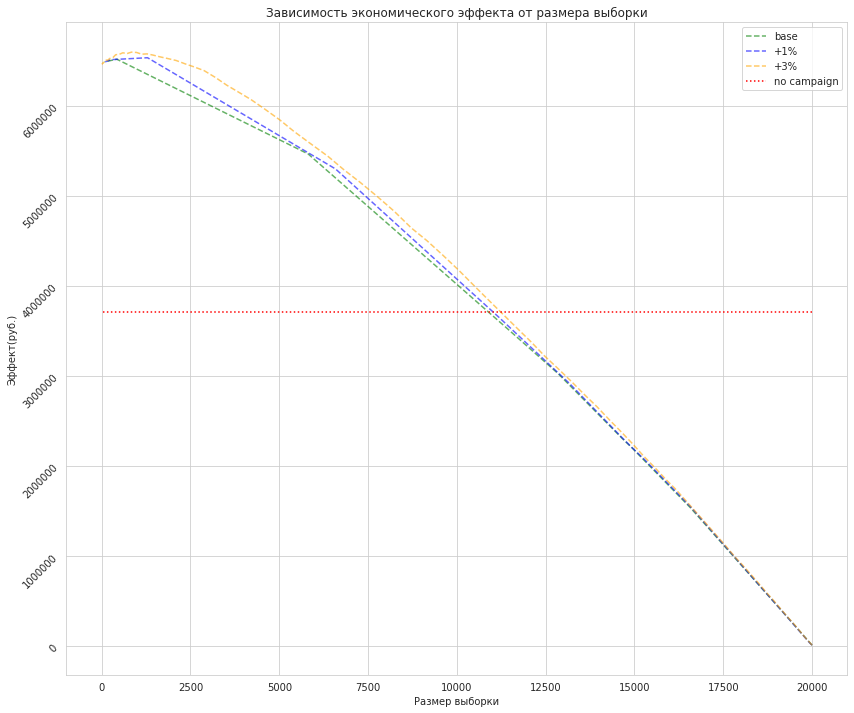

Наиболее оптимальным порогом для второй модели являются 839 пользователей, участвующих в кампании по удержанию, или 4.2% от общего количества


In [374]:
campaign_metrics_3(200, 280, 12, 0.8, 0.012, probs1, probs2, probs)

Как видим, наибольшой доходности лучшая модель достигает на 4.2% пользователей, а кампаниу по удержанию в целом выгодно проводить до 11000 пользователей

# 6 Задание

В целом, вложение средств в реализацию модели может быть оправданным при следующих условиях.

*   Более тщательное прогнозирование притока новых пользователей
*   Изучение того, насколько часто пользователи, склонные к оттоку, откликаются на акции и предложения о скидке.

